In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import glob
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D, \
    Permute, TimeDistributed, Bidirectional, GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
metadata_file = "C:/Extra project/Skin Cancer/HAM10000_metadata.csv"
cancer = pd.read_csv(metadata_file)

In [3]:
cancer["path"] = ""
image_paths = []
for part in ("part_1", "part_2"):
    image_paths += glob.glob("C:/Extra project/Skin Cancer/HAM10000_images_" + part + "/*")
image_ids_n_paths = {os.path.splitext(os.path.basename(path))[0]: path for path in image_paths}
cancer['path'] = cancer['image_id'].map(image_ids_n_paths)
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
for layer in vgg19.layers:
    layer.trainable = False

In [5]:
x = Flatten()(vgg19.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Update the number of units to match the number of classes in your dataset

In [6]:
model = Model(inputs=vgg19.input, outputs=predictions)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [8]:
train_data, test_val_data = train_test_split(cancer, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,
    x_col="path",
    y_col="dx",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

test_val_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_val_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col="path",
    y_col="dx",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

val_generator = test_val_generator.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col="path",
    y_col="dx",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


In [10]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5, mode="min"),
             tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy", save_best_only=True, filepath="./my_model") ]

In [14]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10
220/220 [==============================] - 1206s 5s/step - loss: 1.2771 - accuracy: 0.6511 - val_loss: 0.9600 - val_accuracy: 0.6720
Epoch 2/10
220/220 [==============================] - 1189s 5s/step - loss: 1.0928 - accuracy: 0.6716 - val_loss: 0.9749 - val_accuracy: 0.6587
Epoch 3/10
220/220 [==============================] - 1189s 5s/step - loss: 1.0738 - accuracy: 0.6745 - val_loss: 1.0092 - val_accuracy: 0.6587
Epoch 4/10
220/220 [==============================] - 1201s 5s/step - loss: 1.0456 - accuracy: 0.6732 - val_loss: 0.9421 - val_accuracy: 0.6587
Epoch 5/10
220/220 [==============================] - 1252s 6s/step - loss: 1.0247 - accuracy: 0.6736 - val_loss: 0.9272 - val_accuracy: 0.6587
Epoch 6/10
220/220 [==============================] - 1189s 5s/step - loss: 1.0059 - accuracy: 0.6773 - val_loss: 0.9216 - val_accuracy: 0.6627


In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

47/47 [==============================] - 209s 4s/step - loss: 0.9004 - accuracy: 0.6751
Test Loss: 0.900377631187439
Test Accuracy: 0.6750998497009277


<AxesSubplot:>

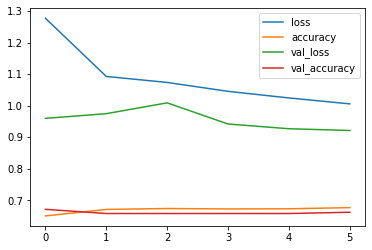

In [16]:
plot_VGG19 = pd.DataFrame(history.history)
plot_VGG19.plot()